In [2]:
#@title Default title text
from google.colab             import drive
drive.mount ('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



PART 1 Start: Data preprocessing...
	> Reading file...
	> Extracting smaller and minimal categories...
	> Synthetically generating new smaller categories...
	> Synthetically generating new minimal categories...
	> Oversampling smaller and minimal categories...
	> Down Sampling the normal class and enormous categories of attack class...
	> Comining all preprocessed data into dataframe...

PART 2 Start: Running training routine...
	> Extracting training data...
	> Encoding Target...
	> Encoding Input...
	> Splitting into Train and Test Data...
	> Scaling Input...
	> Decision Tree: Training model...
	> Inverse Target Encoding...

----------- Classification Report for Decision Tree --------------

              precision    recall  f1-score   support

      attack     0.9998    0.9998    0.9998     71079
      normal     0.9994    0.9995    0.9995     30032

    accuracy                         0.9997    101111
   macro avg     0.9996    0.9996    0.9996    101111
weighted avg     0.9997 

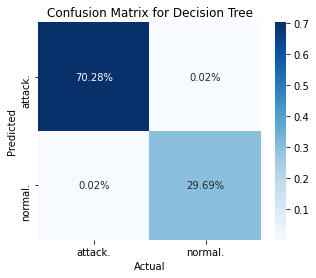

In [4]:
#@title
#!pip install imbalanced-learn     #Uncomment this line if imbalanced-learn is not installed
import shelve;
import warnings;
import time;
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches
import pandas             as pd;
import numpy              as np;
import seaborn            as sns;
import matplotlib.pyplot  as plt;
from sklearn.compose          import make_column_transformer
from sklearn.preprocessing    import OneHotEncoder, StandardScaler
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import confusion_matrix, accuracy_score, f1_score, classification_report,precision_score, recall_score
from sklearn.utils            import resample
from imblearn.over_sampling   import SMOTENC
from sklearn.tree             import DecisionTreeClassifier;

########################## Part 1 Data Preprocessing ##########################
print("\nPART 1 Start: Data preprocessing...")

############ Reading File ############
print("\t> Reading file...")
sh_file   = '/content/drive/MyDrive/Data/shelf_edge_DT'
data_path = '/content/drive/MyDrive/Data/kddcup.data.corrected'

df        = pd.read_csv(data_path, header=None);

for i in range(42):                                       # Rename columns
  df.rename(columns = {i: str(i)}, inplace = True) 

pehele = df['41'].value_counts()


############ Combining smaller categories ############
print("\t> Extracting smaller and minimal categories...")

tmp = pd.DataFrame();
df2 = pd.DataFrame();

few = ['spy.','perl.','phf.','multihop.','ftp_write.','loadmodule.','rootkit.','imap.','warezmaster.','land.','buffer_overflow.','guess_passwd.','pod.']
for fff in few:
  tmp = df.loc[df['41'] == fff];
  df2 = pd.concat([df2,tmp]);
  df.drop(df[df['41'] == fff].index ,inplace=True);    


########### SMOTE Smaller categories ###############
print("\t> Synthetically generating new smaller categories...")


td = df.loc[df['41'] == 'normal.'];
td = resample(td, replace=False, n_samples=450, random_state=1);   ##### C point - size of smaller sample smotes

for i in range(42):                                      
  df2.rename(columns = {i: str(i)}, inplace = True);

few = ['multihop.','ftp_write.','loadmodule.','rootkit.','imap.','warezmaster.','land.','buffer_overflow.','guess_passwd.','pod.'];
smotenc = SMOTENC([1,2,3,6,11,20,21], random_state=1);

for smaller in few:
  tt = df2.loc[df2['41'] == smaller];
  df_tmp = pd.concat([tt,td]);

  X_tmp  = df_tmp.iloc[:,:-1];
  Y_tmp  = np.array(df_tmp.iloc[:,-1]);
  Y_tmp  = Y_tmp.reshape(len(Y_tmp),1);

  X_tmpo ,Y_tmpo = smotenc.fit_resample(X_tmp,Y_tmp);

  X_tmpo = pd.DataFrame(X_tmpo);
  Y_tmpo = pd.DataFrame(Y_tmpo);
  X_tmpo.rename(columns={'0':'123'});

  if smaller == few[0]:
    X_tmt = X_tmpo;
    Y_tmt = Y_tmpo;
  else:
    X_tmt = pd.concat([X_tmt,X_tmpo]); 
    Y_tmt = pd.concat([Y_tmt,Y_tmpo]); 


df_synthesised = pd.DataFrame(np.concatenate((X_tmt,Y_tmt), axis=1));
df_synthesised.drop(df_synthesised[df_synthesised[41] == 'normal.'].index ,inplace=True);

for i in range(42):                                    
  df_synthesised.rename(columns = {i: str(i)}, inplace = True);

df = pd.concat([df,df_synthesised]);


########### SMOTE Minimal categories ###############
print("\t> Synthetically generating new minimal categories...")


td = df.loc[df['41'] == 'normal.'];
td = resample(td, replace=False, n_samples=250, random_state=1);              ##### C point - size of really small smotes

few = ['spy.','perl.','phf.'];
smotenc = SMOTENC([1,2,3], random_state=1);


for smaller in few:
  tt     = df2.loc[df2['41'] == smaller];
  tt     = resample(tt, replace=True, n_samples=10, random_state=1);
  df_tmp = pd.concat([tt,td]);

  X_tmp  = df_tmp.iloc[:,:-1];
  Y_tmp  = np.array(df_tmp.iloc[:,-1]);
  Y_tmp  = Y_tmp.reshape(len(Y_tmp),1);

  X_tmpo ,Y_tmpo = smotenc.fit_resample(X_tmp,Y_tmp);

  X_tmpo = pd.DataFrame(X_tmpo);
  Y_tmpo = pd.DataFrame(Y_tmpo);
  X_tmpo.rename(columns={'0':'123'});

  if smaller == few[0]:
    X_tmt = X_tmpo;
    Y_tmt = Y_tmpo;
  else:
    X_tmt = pd.concat([X_tmt,X_tmpo]); 
    Y_tmt = pd.concat([Y_tmt,Y_tmpo]); 


dft = pd.DataFrame(np.concatenate((X_tmt,Y_tmt), axis=1));
dft.drop(dft[dft[41] == 'normal.'].index ,inplace=True);

for i in range(42):                                     
  dft.rename(columns = {i: str(i)}, inplace = True);

df_synthesised = pd.concat([df_synthesised, dft]);


########### Oversampling ###########
print("\t> Oversampling smaller and minimal categories...")

df_oversampled = resample(df_synthesised, replace=True, n_samples=5000, random_state=1);  ###### C Point - Oversampling weight
df_synthesised = pd.concat([df_synthesised,df_oversampled]);


############ Down Sampling ############
print("\t> Down Sampling the normal class and enormous categories of attack class...")

df_down = df;

for str1 in ['normal.','smurf.', 'neptune.']:
  new = df_down.loc[df_down['41']==str1]
  if str1 == 'normal.':
    new = new.sample(n=150000, replace=False, random_state=1 );
  else:
    new = new.sample(n=150000, replace=False, random_state=1 );
  df_down.drop(df_down[df_down['41']==str1].index ,inplace=True)
  df_down = pd.concat([new, df_down]);

df_finalsample = pd.concat([df_down,df_synthesised]);
beechka = df_finalsample['41'].value_counts();


############ Combining ############
print("\t> Comining all preprocessed data into dataframe...")

dfnormal = df_finalsample.loc[df_finalsample['41']=='normal.']
dfattack = df_finalsample.loc[df_finalsample['41']!='normal.']
dfattack['41'] = 'attack.'

df = pd.concat([dfnormal,dfattack]);
baadka = df['41'].value_counts();



########################## Part 2 Training Model ##########################
print("\nPART 2 Start: Running training routine...")


############ Getting Training data ############
print("\t> Extracting training data...")
X         = df.iloc[:,:-1];
Y         = np.array(df.iloc[:,-1]);
Y         = Y.reshape(len(Y),1)


############ Target Encoding ############
print("\t> Encoding Target...")
Y = pd.DataFrame(Y);
Y.loc[Y[0] != 'normal.',0] = 1;
Y.loc[Y[0] == 'normal.',0] = 0;
#Y[0].Weight = Y[0].Weight.astype('int64')
Y = np.array(Y);
Y  = Y.astype(float)


############ Input Encoding for columns 1,2,3 ############
print("\t> Encoding Input...")
IE = make_column_transformer((OneHotEncoder(),['1','2','3']),remainder = 'passthrough');
IE.fit(X);
X = pd.DataFrame(IE.transform(X));


############ Train test split (80%, 20% ratio) ############
print("\t> Splitting into Train and Test Data...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1);
Y_train = Y_train.reshape(len(Y_train),1)
Y_test  = Y_test.reshape(len(Y_test),1)


############# Scaling Input #############
print("\t> Scaling Input...")
SCALE_IN  = StandardScaler();
SCALE_IN.fit(X_train);
X_train = SCALE_IN.transform(X_train);

X_test  = SCALE_IN.transform(X_test);
input_dimension = 122;            


############# Decision Tree Model #############
print("\t> Decision Tree: Training model...")
Y_train = Y_train.flatten();
Y_test  = Y_test.flatten();

MODEL = DecisionTreeClassifier()
MODEL.fit(X_train, Y_train)
Y_pred = MODEL.predict(X_test)

Y_pred_prob = MODEL.predict_proba(X_test);


############# Inverse Label Encoding and Results #############
print("\t> Inverse Target Encoding...")

Y_pred = Y_pred.astype('int');
Y_test = Y_test.astype('int');

Y_pred = pd.DataFrame(Y_pred);
Y_test = pd.DataFrame(Y_test);

Y_pred.loc[Y_pred[0] != 0,0] = 'attack';
Y_pred.loc[Y_pred[0] == 0,0] = 'normal';

Y_test.loc[Y_test[0] != 0,0] = 'attack';
Y_test.loc[Y_test[0] == 0,0] = 'normal';


############# Visualising test Results #############
print("\n----------- Classification Report for Decision Tree --------------\n")
print(classification_report(Y_test,Y_pred,digits=4))
print("\n------------------------------------------------------------------\n")


plt.rcParams["figure.figsize"] = (5,4);
cm1 = confusion_matrix(Y_test,Y_pred);
sns.heatmap(cm1/np.sum(cm1), annot=True, fmt='.2%', cmap='Blues', xticklabels=['attack.','normal.'], yticklabels=['attack.','normal.']);
plt.title('Confusion Matrix for Decision Tree');
plt.ylabel('Predicted');
plt.xlabel('Actual');
plt.show();



PART 3: Testing overall trained model
	> Creating prediction pipeline function...
	> Reading file...
	> Generating performance metrics for 25 random samples...

Testing results averaged over 25 samples:
	Average Accuracy - 0.9998859999999999
	Average F1 Score - 0.9998206681214935


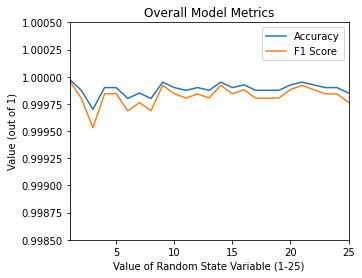

	> Generating speed charachteristics for 25 random samples...


Average Speed of prediction for 25 samples - 284371.1601006707 packets/sec


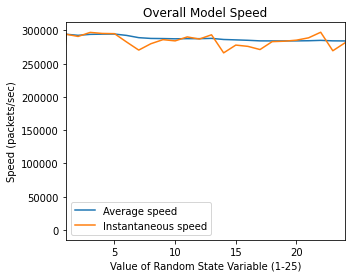



PART 4 Start: Shelving models, encoders etc...
	> Shelving IE...
	> Shelving SCALE_IN...
	> Shelving MODEL...


			 THANK YOU


In [5]:
#@title

########################## Part 3 Prediction pipleine and testing ##########################
print("\n\nPART 3: Testing overall trained model")

############# Prediction pipeline function #############
print("\t> Creating prediction pipeline function...")

def PREDICTOR(data, verbose=1):
  d = pd.DataFrame(data);
  sh = d.shape;
  if verbose==1:
    print("\n\tPREDICTOR() called: {} Columns to predict!".format(sh[0]));
  if sh[1]==41:

    # Column naming
    for i in range(41):
      d.rename(columns = {i: str(i)}, inplace = True) 
      
    # Column division
    if verbose==1:
      print("\t\u2022 Diving columns..")
    X_pred = d.iloc[:,:];

    # Encoding categorical variables
    if verbose==1:
      print("\t\u2022 Encoding..")
    X_pred = pd.DataFrame(IE.transform(X_pred));

    # Scaling
    if verbose==1:
      print("\t\u2022 Scaling..")
    X_pred = SCALE_IN.transform(X_pred);
  
    # Prediction
    if verbose==1:  
      print("\t\u2022 Decision Tree Prediction...")
    Y_pred = MODEL.predict(X_pred);
    
    # Decoding
    if verbose==1:
      print("\t\u2022 Decoding...")
    Y_pred = pd.DataFrame(Y_pred);
    Y_pred.loc[Y_pred[0] != 0, 0] = 'attack.'
    Y_pred.loc[Y_pred[0] == 0, 0] = 'normal.'


    if verbose==1:
      print("\t\u2022 PREDICTOR: Complete\n");
    return pd.DataFrame(Y_pred);

  else:
    if verbose==1:
      print("Error! Wrong format of input!");
    return 0;


############# Test Bench #############

print("\t> Reading file...")
#Note: Use the dataframe df_test to assign test bench data, not df.
df_test        = pd.read_csv(data_path, header=None);


############# Performance Metrics #############
print("\t> Generating performance metrics for 25 random samples...")

f1c = 0;
acc = 0;
ac_values = np.array([0]);
f1_values = np.array([0]);

for rx in range(25):
  finalT = pd.DataFrame(df_test .sample(n=40000, replace=False, random_state=rx+1 ))

  X_finalT = pd.DataFrame(finalT.iloc[:,:-1]);
  Y_finalT = pd.DataFrame(finalT.iloc[:,-1]);
  Y_finalT.loc[Y_finalT[41] != 'normal.',41] = 'attack.'

  Y_finalP = PREDICTOR(X_finalT,0);                       # Non verbose silent run

  a1 = accuracy_score(Y_finalT,Y_finalP)
  f1 = f1_score(Y_finalT,Y_finalP, average='macro')
  acc = acc + a1;
  f1c = f1c + f1;

  ac_values =np.append(ac_values,a1);
  f1_values =np.append(f1_values,f1);

f1c = f1c/25;
acc = acc/25;

print("\nTesting results averaged over 25 samples:")
print("\tAverage Accuracy - "+str(acc));
print("\tAverage F1 Score - "+str(f1c));

plt.plot(ac_values,label = 'Accuracy');
plt.plot(f1_values,label = 'F1 Score' );
plt.legend();
plt.xlabel("Value of Random State Variable (1-25)");
plt.ylabel("Value (out of 1)")
plt.ylim(0.9985,1.0005);
plt.xlim(0.99,25);
plt.rcParams["figure.figsize"] = (5,4);
plt.title('Overall Model Metrics')
plt.show();


############# Prediction speed #############
print("\t> Generating speed charachteristics for 25 random samples...")

time_total    = 0;
sample_total  = 0;
time_values   = np.array([0]);
sample_values = np.array([0]);
avg_speed     = np.array([0]);
inst_speed    = np.array([0]);

for rx in range(26):
  finalT = pd.DataFrame(df_test .sample(n=40000, replace=False, random_state=rx+1 ))

  X_finalT = pd.DataFrame(finalT.iloc[:,:-1]);
  t_init = time.clock();
  Y_finalP = PREDICTOR(X_finalT,0);                       # Non verbose silent run
  t1 = time.clock() - t_init;
  s1 = 40000
  time_total   = time_total   + t1;
  sample_total = sample_total + s1;

  if rx!=25:
    time_values   = np.append(time_values,t1);
    sample_values = np.append(sample_values,s1);
    avg_speed     = np.append(avg_speed,sample_total/time_total);
    inst_speed    = np.append(inst_speed,s1/t1);

print("\n\nAverage Speed of prediction for 25 samples - "+str(avg_speed[25])+" packets/sec");

plt.plot(avg_speed,label = 'Average speed');
plt.plot(inst_speed,label = 'Instantaneous speed' );
plt.legend();
plt.xlabel("Value of Random State Variable (1-25)");
plt.ylabel("Speed (packets/sec)")
plt.xlim(1,24);
plt.rcParams["figure.figsize"] = (5,4);
plt.title('Overall Model Speed')
plt.show();


########################## Part 4 Export Workspace ##########################
print("\n\nPART 4 Start: Shelving models, encoders etc...");
shelver = shelve.open(sh_file,'n') 

shelve_list = ['IE','SCALE_IN','MODEL']

for k in shelve_list:
  try:
    print("\t> Shelving "+k+"...");
    shelver[k] = globals()[k]
  except TypeError:
    print('ERROR shelving: {}'.format(k));

shelver.close()

print("\n\n\t\t\t THANK YOU")

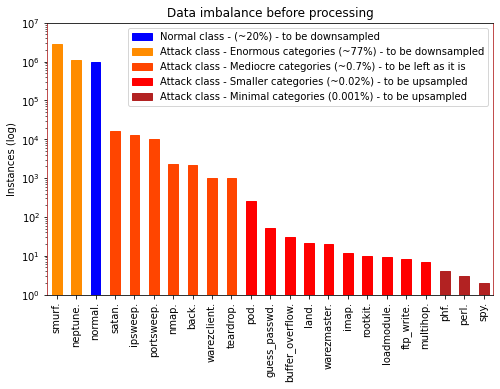

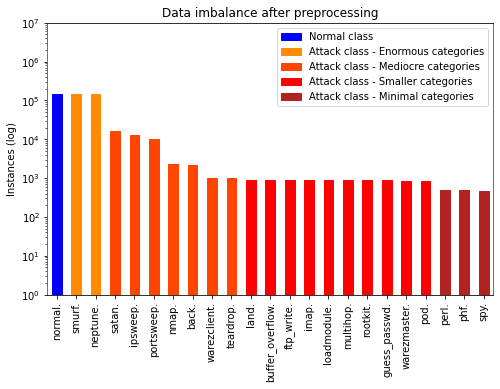

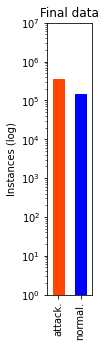

In [6]:
########################## Data Visualisation of Preprocessing stage ##########################

############# PLOT 1: Before Preprocessing #############
col1 = 'b'
col2 = 'darkorange'
col3 = 'orangered'
col4 = 'red'
col5 = 'firebrick'

plt.rcParams["figure.figsize"] = (8,5);
FIG2  = plt.figure();
FIG2a = FIG2.add_subplot(111);
FIG2a = pehele.plot(kind = 'bar');
for tt in range(25):
  if tt==2:
    FIG2a.get_children()[tt].set_color(col1);
  elif tt<3:
    FIG2a.get_children()[tt].set_color(col2);
  elif tt<10:
    FIG2a.get_children()[tt].set_color(col3);
  elif tt<20:
    FIG2a.get_children()[tt].set_color(col4);
  else:
    FIG2a.get_children()[tt].set_color(col5);


plt.yscale('log');
p1 = mpatches.Patch(color=col1, label = 'Normal class - (~20%) - to be downsampled');
p2 = mpatches.Patch(color=col2, label = 'Attack class - Enormous categories (~77%) - to be downsampled');
p3 = mpatches.Patch(color=col3, label = 'Attack class - Mediocre categories (~0.7%) - to be left as it is');
p4 = mpatches.Patch(color=col4, label = 'Attack class - Smaller categories (~0.02%) - to be upsampled');
p5 = mpatches.Patch(color=col5, label = 'Attack class - Minimal categories (0.001%) - to be upsampled');


plt.ylim(1,10000000);
plt.title('Data imbalance before processing');
plt.ylabel('Instances (log)');
plt.legend(handles=[p1,p2,p3,p4,p5]);
plt.show();
print('\n\n')


############# PLOT 2: After Preprocessing #############

plt.rcParams["figure.figsize"] = (8,5);
FIG2  = plt.figure();
FIG2a = FIG2.add_subplot(111);
FIG2a = beechka.plot(kind = 'bar');
for tt in range(25):
  if tt==0:
    FIG2a.get_children()[tt].set_color(col1);
  elif tt<3:
    FIG2a.get_children()[tt].set_color(col2);
  elif tt<10:
    FIG2a.get_children()[tt].set_color(col3);
  elif tt<20:
    FIG2a.get_children()[tt].set_color(col4);
  else:
    FIG2a.get_children()[tt].set_color(col5);


plt.yscale('log');
p1 = mpatches.Patch(color=col1, label = 'Normal class');
p2 = mpatches.Patch(color=col2, label = 'Attack class - Enormous categories');
p3 = mpatches.Patch(color=col3, label = 'Attack class - Mediocre categories');
p4 = mpatches.Patch(color=col4, label = 'Attack class - Smaller categories');
p5 = mpatches.Patch(color=col5, label = 'Attack class - Minimal categories');


plt.ylim(1,10000000);
plt.title('Data imbalance after preprocessing');
plt.ylabel('Instances (log)');
plt.legend(handles=[p1,p2,p3,p4,p5]);
plt.show();
print('\n\n')


############# PLOT 3: Final Combined Data #############

plt.rcParams["figure.figsize"] = (0.8,5);
FIG1  = plt.figure();
FIG1a = FIG1.add_subplot(111);
#plt.bar(width=[1,1]);
FIG1a = baadka.plot(kind = 'bar');
for tt in range(2):
  if tt==0:
    FIG1a.get_children()[tt].set_color(col3);
  else:
    FIG1a.get_children()[tt].set_color(col1);

plt.yscale('log');
plt.ylabel('Instances (log)');
plt.ylim(1,10000000);
plt.title('Final data');
plt.show()